<a href="https://colab.research.google.com/github/Abhilaksh1498/SoC-20-Chatbot/blob/master/EE338.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESPCN (Efficient Sub-Pixel CNN), is a model that reconstructs a high-resolution version of an image given a low-resolution version. 

Here, we will implement the model from the paper *Real-Time Single Image and Video Super-Resolution Using an Efficient
Sub-Pixel Convolutional Neural Network* and dataset being BSDS500.


**Link to Paper**
```
https://arxiv.org/pdf/1609.05158.pdf
```

**Datset Link**


```
https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html
```





In [1]:
import tensorflow as tf

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display

In [2]:
# Downloading the dataset
# dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
# root_dir = os.path.join(data_dir, "BSDS500/data")

! wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz


--2020-12-05 05:18:08--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8000::1, 2620:12a:8001::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2020-12-05 05:18:08--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2020-12-05 05:18:08--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

In [3]:
! tar zxvf BSR_bsds500.tgz 

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
BSR/bench/source/Matrix.hh
BSR/bench/source/csa.hh
BSR/bench/source/String.hh
BSR/bench/bench_bsds500.m
BSR/bench/data/
BSR/bench/data/groundTruth/
BSR/bench/data/groundTruth/6046.mat
BSR/bench/data/groundTruth/2018.mat
BSR/bench/data/groundTruth/8068.mat
BSR/bench/

In [4]:

crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 10


train_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode = None
)

valid_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=42, label_mode = None
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [5]:
# We need to normalise pixel values in any Computer Vision task

def normalise_img(img):
    img = img / 255.0
    return img


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(normalise_img)
valid_ds = valid_ds.map(normalise_img)



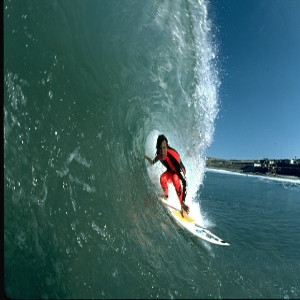

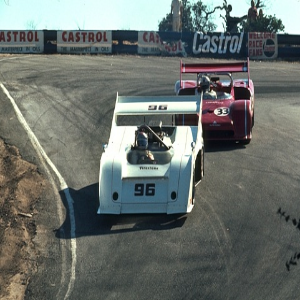

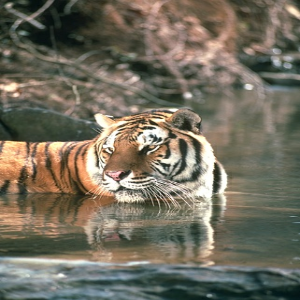

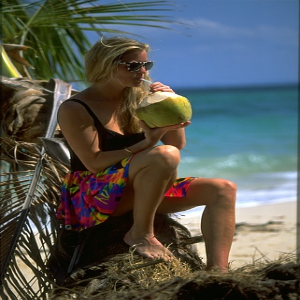

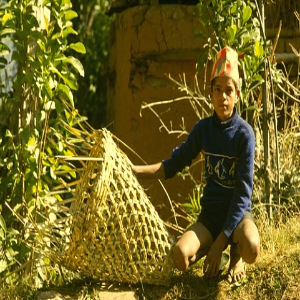

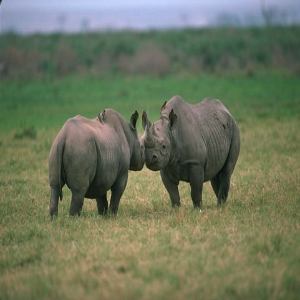

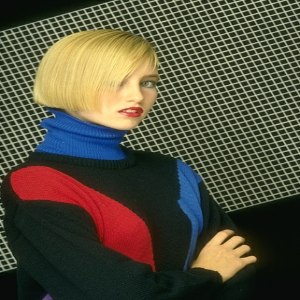

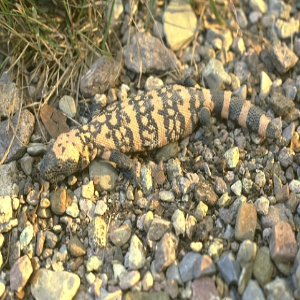

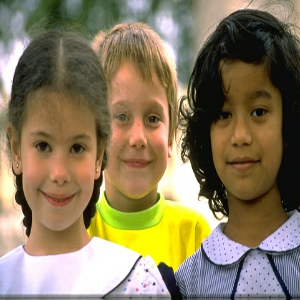

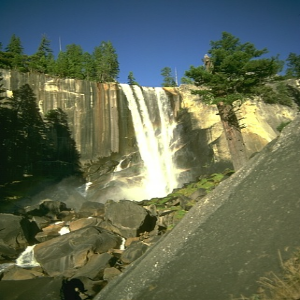

In [6]:
# This is how input images to the model looks
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))  # array_to_img function displays numpy array as image
    # this will display 10 imgs as batch_size was set to 10 previously

# Image preprocessing
We need some cropping and resizing of input and output images to be fed to model before during training.

Here we convert RGB img to YUV space and retain only Y component followed by resizing image

In [7]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)


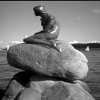

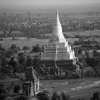

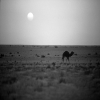

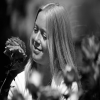

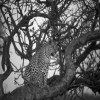

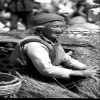

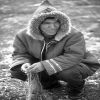

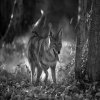

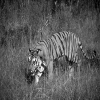

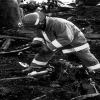

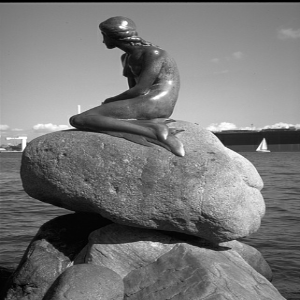

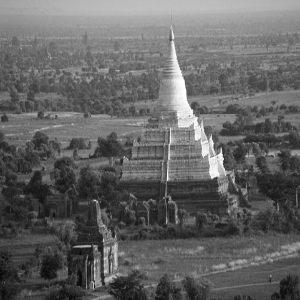

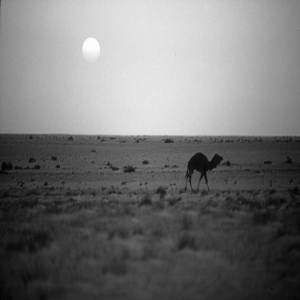

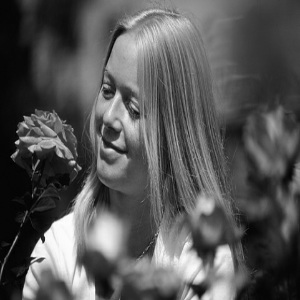

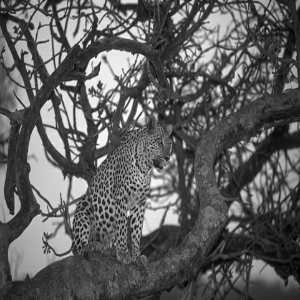

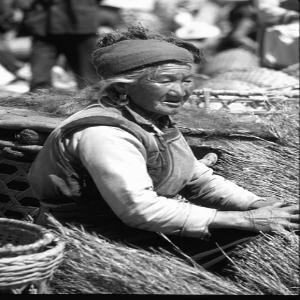

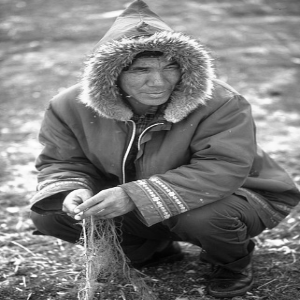

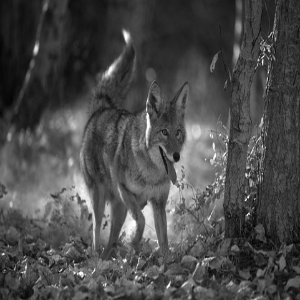

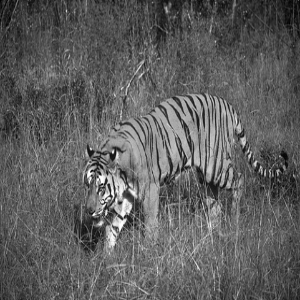

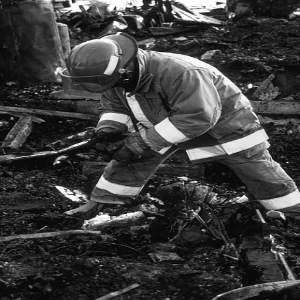

In [8]:
# Visualising i/p and o/p images that are fed to model for training
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))    # i/p images to model
    for img in batch[1]:
        display(array_to_img(img))    #output images for model

# Building the Model

In [9]:
channels = 1
inputs = keras.Input(shape=(None, None, channels))
x = layers.Conv2D(64, 5, padding='same', activation='tanh')(inputs)
x = layers.Conv2D(64, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(32, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same', activation='tanh')(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf_op_layer_DepthToSpace (Te [(None, None, None, 1)]   0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
__________________________________________________

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# some useful functions
def get_low_res_img(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display the PSNR - main metric we use to evaluate super-resolution performance.

**PSNR** : Peak Signal-to-Noise Ratio is a metric of how "closely" the super-resolved image reconstructed from its low-res value resembles the original high quality image.

In [18]:
class ESPCNCallBack(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallBack, self).__init__()
        self.test_img = get_low_res_img(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

Epoch 1/100
Mean PSNR for epoch: 19.91


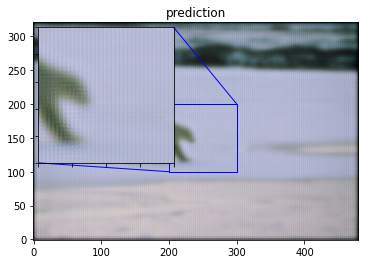

40/40 - 3s - loss: 0.0275 - val_loss: 0.0099
Epoch 2/100
Mean PSNR for epoch: 21.83
40/40 - 3s - loss: 0.0087 - val_loss: 0.0071
Epoch 3/100
Mean PSNR for epoch: 21.64
40/40 - 2s - loss: 0.0073 - val_loss: 0.0066
Epoch 4/100
Mean PSNR for epoch: 22.46
40/40 - 2s - loss: 0.0060 - val_loss: 0.0054
Epoch 5/100
Mean PSNR for epoch: 22.15
40/40 - 2s - loss: 0.0057 - val_loss: 0.0065
Epoch 6/100
Mean PSNR for epoch: 22.82
40/40 - 2s - loss: 0.0056 - val_loss: 0.0055
Epoch 7/100
Mean PSNR for epoch: 23.61
40/40 - 3s - loss: 0.0050 - val_loss: 0.0047
Epoch 8/100
Mean PSNR for epoch: 23.73
40/40 - 2s - loss: 0.0048 - val_loss: 0.0044
Epoch 9/100
Mean PSNR for epoch: 24.03
40/40 - 2s - loss: 0.0047 - val_loss: 0.0045
Epoch 10/100
Mean PSNR for epoch: 23.91
40/40 - 2s - loss: 0.0047 - val_loss: 0.0043
Epoch 11/100
Mean PSNR for epoch: 24.00
40/40 - 2s - loss: 0.0048 - val_loss: 0.0042
Epoch 12/100
Mean PSNR for epoch: 23.71
40/40 - 3s - loss: 0.0045 - val_loss: 0.0042
Epoch 13/100
Mean PSNR for e

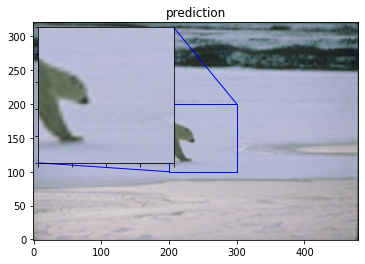

40/40 - 3s - loss: 0.0044 - val_loss: 0.0041
Epoch 22/100
Mean PSNR for epoch: 23.46
40/40 - 3s - loss: 0.0044 - val_loss: 0.0044
Epoch 23/100
Mean PSNR for epoch: 23.90
40/40 - 2s - loss: 0.0046 - val_loss: 0.0043
Epoch 24/100
Mean PSNR for epoch: 23.94
40/40 - 2s - loss: 0.0044 - val_loss: 0.0042
Epoch 25/100
Mean PSNR for epoch: 23.90
40/40 - 3s - loss: 0.0044 - val_loss: 0.0044
Epoch 26/100
Mean PSNR for epoch: 24.13
40/40 - 3s - loss: 0.0047 - val_loss: 0.0041
Epoch 27/100
Mean PSNR for epoch: 23.84
40/40 - 2s - loss: 0.0045 - val_loss: 0.0041
Epoch 28/100
Mean PSNR for epoch: 23.75
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 29/100
Mean PSNR for epoch: 23.23
40/40 - 2s - loss: 0.0048 - val_loss: 0.0044
Epoch 30/100
Mean PSNR for epoch: 24.09
40/40 - 2s - loss: 0.0045 - val_loss: 0.0041
Epoch 31/100
Mean PSNR for epoch: 23.83
40/40 - 2s - loss: 0.0043 - val_loss: 0.0041
Epoch 32/100
Mean PSNR for epoch: 24.12
40/40 - 2s - loss: 0.0044 - val_loss: 0.0040
Epoch 33/100
Mean PS

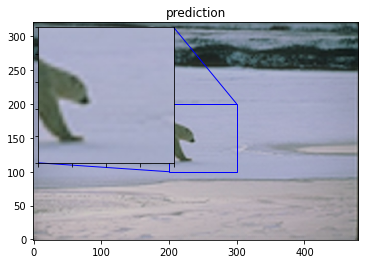

40/40 - 3s - loss: 0.0043 - val_loss: 0.0047
Epoch 42/100
Mean PSNR for epoch: 24.00
40/40 - 2s - loss: 0.0045 - val_loss: 0.0041
Epoch 43/100
Mean PSNR for epoch: 23.86
40/40 - 2s - loss: 0.0043 - val_loss: 0.0041
Epoch 44/100
Mean PSNR for epoch: 24.01
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 45/100
Mean PSNR for epoch: 23.24
40/40 - 2s - loss: 0.0044 - val_loss: 0.0047
Epoch 46/100
Mean PSNR for epoch: 24.17
40/40 - 2s - loss: 0.0046 - val_loss: 0.0040
Epoch 47/100
Mean PSNR for epoch: 23.70
40/40 - 2s - loss: 0.0042 - val_loss: 0.0043
Epoch 48/100
Mean PSNR for epoch: 23.73
40/40 - 2s - loss: 0.0044 - val_loss: 0.0042
Epoch 49/100
Mean PSNR for epoch: 23.99
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 50/100
Mean PSNR for epoch: 24.00
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 51/100
Mean PSNR for epoch: 23.59
40/40 - 3s - loss: 0.0043 - val_loss: 0.0041
Epoch 52/100
Mean PSNR for epoch: 24.00
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 53/100
Mean PS

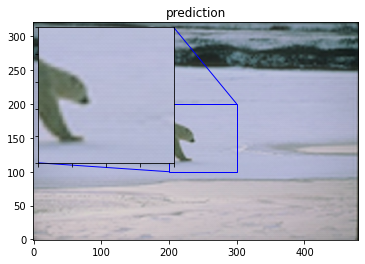

40/40 - 3s - loss: 0.0044 - val_loss: 0.0040
Epoch 62/100
Mean PSNR for epoch: 24.07
40/40 - 3s - loss: 0.0043 - val_loss: 0.0040
Epoch 63/100
Mean PSNR for epoch: 23.50
40/40 - 2s - loss: 0.0043 - val_loss: 0.0046
Epoch 64/100
Mean PSNR for epoch: 24.22
40/40 - 2s - loss: 0.0044 - val_loss: 0.0040
Epoch 65/100
Mean PSNR for epoch: 23.95
40/40 - 3s - loss: 0.0042 - val_loss: 0.0042
Epoch 66/100
Mean PSNR for epoch: 23.81
40/40 - 2s - loss: 0.0043 - val_loss: 0.0044
Epoch 67/100
Mean PSNR for epoch: 23.71
40/40 - 2s - loss: 0.0045 - val_loss: 0.0043
Epoch 68/100
Mean PSNR for epoch: 24.14
40/40 - 2s - loss: 0.0045 - val_loss: 0.0039
Epoch 69/100
Mean PSNR for epoch: 23.65
40/40 - 2s - loss: 0.0043 - val_loss: 0.0041
Epoch 70/100
Mean PSNR for epoch: 23.35
40/40 - 2s - loss: 0.0043 - val_loss: 0.0045
Epoch 71/100
Mean PSNR for epoch: 24.14
40/40 - 2s - loss: 0.0043 - val_loss: 0.0039
Epoch 72/100
Mean PSNR for epoch: 23.65
40/40 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 73/100
Mean PS

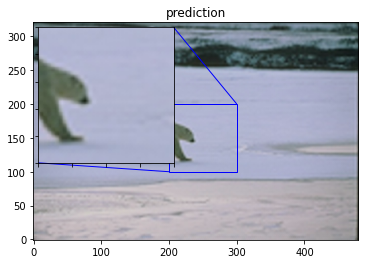

40/40 - 3s - loss: 0.0042 - val_loss: 0.0040
Epoch 82/100
Mean PSNR for epoch: 24.50
40/40 - 3s - loss: 0.0043 - val_loss: 0.0040
Epoch 83/100
Mean PSNR for epoch: 24.10
40/40 - 3s - loss: 0.0044 - val_loss: 0.0039
Epoch 84/100
Mean PSNR for epoch: 23.92
40/40 - 2s - loss: 0.0042 - val_loss: 0.0040
Epoch 85/100
Mean PSNR for epoch: 24.15
40/40 - 2s - loss: 0.0042 - val_loss: 0.0040
Epoch 86/100
Mean PSNR for epoch: 23.84
40/40 - 3s - loss: 0.0042 - val_loss: 0.0042
Epoch 87/100
Mean PSNR for epoch: 24.33
40/40 - 3s - loss: 0.0042 - val_loss: 0.0040
Epoch 88/100
Mean PSNR for epoch: 23.60
40/40 - 2s - loss: 0.0042 - val_loss: 0.0043
Epoch 89/100
Mean PSNR for epoch: 23.94
40/40 - 2s - loss: 0.0043 - val_loss: 0.0040
Epoch 90/100
Mean PSNR for epoch: 24.40
40/40 - 2s - loss: 0.0042 - val_loss: 0.0039
Epoch 91/100
Mean PSNR for epoch: 24.46
40/40 - 2s - loss: 0.0042 - val_loss: 0.0039
Epoch 92/100
Mean PSNR for epoch: 24.07
40/40 - 2s - loss: 0.0042 - val_loss: 0.0039
Epoch 93/100
Mean PS

In [20]:
epochs = 100
# we also need to save the model while training so as to make predictions later on
checkpoint_filepath = "/tmp/checkpoint"  # directory where model wts will be saved


model.compile(
    optimizer=keras.optimizers.Adam(lr = .001), loss=keras.losses.MeanSquaredError())

model.fit(
    train_ds, epochs=epochs, validation_data=valid_ds, verbose = 2, callbacks = [ESPCNCallBack(), keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_filepath,
        save_weights_only=True,
        monitor="loss",
        mode="min",
        save_best_only=True,   # we will only save the best model, best => min MSE loss 
    )]
)


In [21]:
# Loading the "best" model that was achieved during training
model.load_weights(checkpoint_filepath)

# Save the entire model as a SavedModel, so that we can download it and dont need to retrain again and again
!mkdir -p saved_model
model.save('saved_model/my_model')

# # Reload a fresh Keras model from the saved model:
# new_model = tf.keras.models.load_model('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Predictions :)

In [15]:
# we also need to create a list of test images (with location) for inference model

test_img_paths = []
for file_name in os.listdir('/content/BSR/BSDS500/data/images/test/'):
  if file_name[-4:] == ".jpg":
    test_img_paths.append('/content/BSR/BSDS500/data/images/test/'+file_name)
    
test_img_paths.sort()    # 200 test images


PSNR of predict and high resolution is 25.663


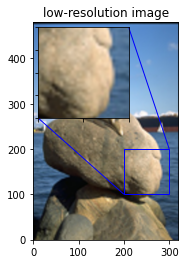

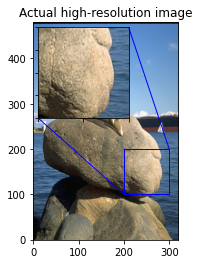

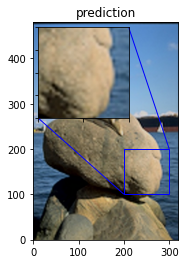

PSNR of predict and high resolution is 22.529


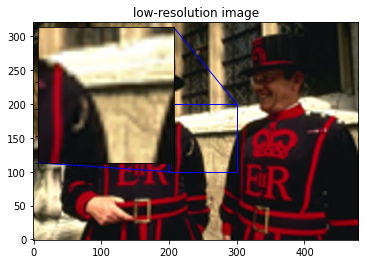

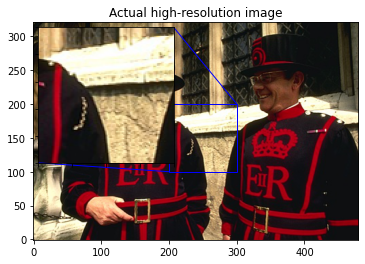

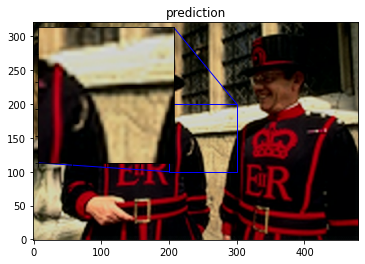

PSNR of predict and high resolution is 23.272


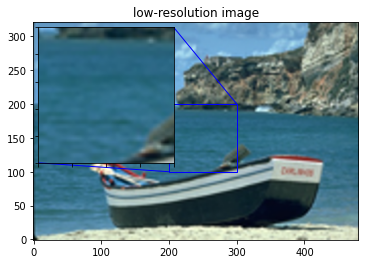

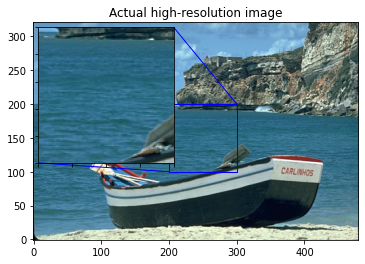

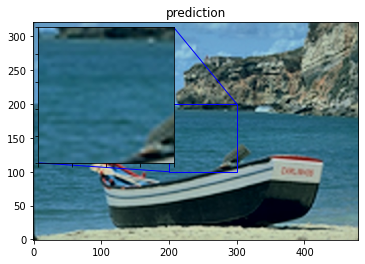

PSNR of predict and high resolution is 25.965


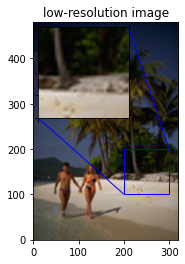

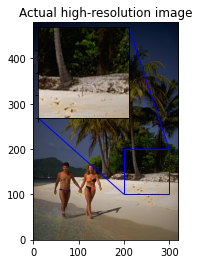

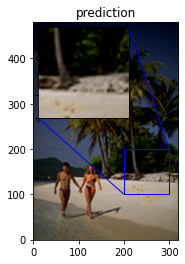

PSNR of predict and high resolution is 19.981


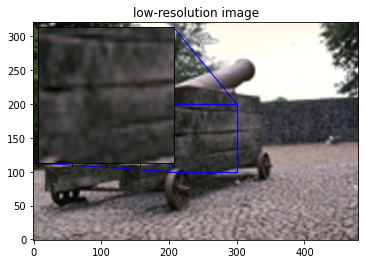

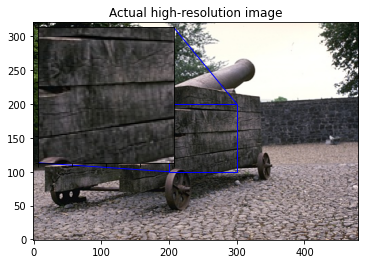

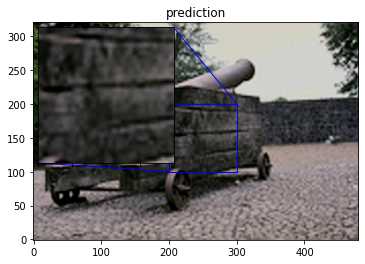

Avg. PSNR of reconstructions is 11.741


In [27]:
total_test_psnr = 0.0
import random
i = random.randint(0,190)
for index, test_img_path in enumerate(test_img_paths[i:i+5]):  # we'll be running inference model on batch of 5 images
    img = load_img(test_img_path)
    lowres_input = get_low_res_img(img, upscale_factor)
    width = lowres_input.size[0] * upscale_factor
    height = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((width, height))
    lowres_img = lowres_input.resize((width, height))
    prediction = upscale_image(model, lowres_input) 
    test_psnr = tf.image.psnr(img_to_array(prediction), img_to_array(highres_img), max_val=255)

    total_test_psnr += test_psnr

    print("PSNR of predict and high resolution is %.3f" % test_psnr)
    plot_results(lowres_img, index, "low-resolution image")
    plot_results(highres_img, index, "Actual high-resolution image")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of reconstructions is %.3f" % (total_test_psnr / 10))